In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
import matplotlib.pyplot as plt

# always import gbm_algos first !
import xgboost, lightgbm, catboost

# Core
import numpy as np
import scipy.io as io
from torch.autograd import grad
from torch.utils.data import DataLoader, Dataset

# Sklearn
from sklearn.ensemble import RandomForestRegressor
from mlens.ensemble import SuperLearner

# Let's do facy optimizers
from optimizers import Lookahead, AdamGC, SGDGC
from madgrad import MADGRAD
from lbfgsnew import LBFGSNew
# Modify at /usr/local/lib/python3.9/site-packages/torch_lr_finder/lr_finder.py
from torch_lr_finder import LRFinder
from onecyclelr import OneCycleLR
import pcgrad
from pytorch_stats_loss import torch_wasserstein_loss, torch_energy_loss
from geomloss import SamplesLoss
from utils import *

from tqdm import trange

[MLENS] backend: threading


[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [2]:
DATA_PATH = "/Users/pongpisit/Desktop/research/pinn/Solving-Differential-Equations-with-Neural-Networks/SymbolicMathematics/data/burgers_shock.mat"
data = io.loadmat(DATA_PATH)

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

N = 250
print(f"Training with {N} samples")
idx = np.random.choice(X_star.shape[0], N, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx,:]

# Unsup data
N_res = N//2
idx_res = np.array(range(X_star.shape[0]-1))[~idx]
idx_res = np.random.choice(idx_res.shape[0], N_res, replace=True)
X_res = X_star[idx_res, :]
print(f"Training with {N_res} unsup samples")
X_u_train = np.vstack([X_u_train, X_res])
u_train = np.vstack([u_train, torch.rand(X_res.shape[0], 1) - 1000])
# del X_res

# Convert to torch.tensor
X_u_train = torch.tensor(X_u_train).float().requires_grad_(True)
u_train = torch.tensor(u_train).float().requires_grad_(True)
X_star = torch.tensor(X_star).float().requires_grad_(True)
u_star = torch.tensor(u_star).float().requires_grad_(True)
# lb and ub are used in adversarial training
scaling_factor = 1.0
lb = scaling_factor*to_tensor(lb, False)
ub = scaling_factor*to_tensor(ub, False)

feature_names=('uf', 'u_x', 'u_xx', 'u_xxx', 'x')

Training with 250 samples
Training with 125 unsup samples


In [3]:
class Network(nn.Module):
    def __init__(self, model, index2features=('uf', 'u_x',  'u_xx', 'u_tt', 'u_xt', 'u_tx')):
        super(Network, self).__init__()
        # pls init the self.model before
        self.model = model
        # For tracking, the default tup is for the burgers' equation.
        self.index2features = index2features
        print("Considering", self.index2features)
        self.diff_flag = diff_flag(self.index2features)
        self.uf = None
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, x, t):
        self.uf = self.model(torch.cat([x, t], dim=1))
        return self.uf
    
    def get_selector_data(self, x, t):
        uf = self.forward(x, t)
        u_t = self.gradients(uf, t)[0]
        
        ### PDE Loss calculation ###
        # Without calling grad
        derivatives = []
        for t in self.diff_flag[0]:
            if t=='uf': derivatives.append(uf)
            elif t=='x': derivatives.append(x)
        # With calling grad
        for t in self.diff_flag[1]:
            out = uf
            for c in t:
                if c=='x': out = self.gradients(out, x)[0]
                elif c=='t': out = self.gradients(out, t)[0]
            derivatives.append(out)
        
        return torch.cat(derivatives, dim=1), u_t
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))

In [5]:
class SeclectorNetwork(nn.Module):
    def __init__(self, X_train_dim, bn=None):
        super().__init__()
        # Nonlinear model, Training with PDE reg.
        self.nonlinear_model = TorchMLP(dimensions=[X_train_dim, 50, 50, 1], activation_function=nn.Tanh, bn=bn, dropout=nn.Dropout(p=0.1), inp_drop=False)
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, inn):
        ut_approx = self.nonlinear_model(inn)
        return ut_approx
    
    def loss(self, X_input, y_input):
        ut_approx = self.forward(X_input)
        mse_loss = F.mse_loss(ut_approx, y_input, reduction='mean')
        return mse_loss

class AttentionSelectorNetwork(nn.Module):
    def __init__(self, layers, bn=None, reg_intensity=0.2):
        super(AttentionSelectorNetwork, self).__init__()
        # Nonlinear model, Training with PDE reg.
        assert len(layers) > 1
        self.linear1 = nn.Linear(layers[0], layers[0])
        self.nonlinear_model = TorchMLP(dimensions=layers, activation_function=nn.Tanh, bn=bn, dropout=nn.Dropout(p=0.1))
        self.latest_weighted_features = None
        self.th = nn.Parameter(to_tensor(0.5, True))
        self.reg_intensity = reg_intensity
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, inn):
        return self.nonlinear_model(inn*self.weighted_features(inn))
    
    def weighted_features(self, inn):
        self.latest_weighted_features =  torch.sigmoid(self.linear1(inn)).mean(axis=0)
        return (self.latest_weighted_features > self.th).float()
    
    def loss(self, X_input, y_input):
        ut_approx = self.forward(X_input)
        mse_loss = F.mse_loss(ut_approx, y_input, reduction='mean')
        return mse_loss+self.reg_intensity*torch.norm((self.latest_weighted_features > self.th).float(), p=0)

class SemiSupModel(nn.Module):
    def __init__(self, network, selector, normalize_derivative_features=False, mini=None, maxi=None):
        super(SemiSupModel, self).__init__()
        self.network = network
        self.selector = selector
        self.normalize_derivative_features = normalize_derivative_features
        self.mini = mini
        self.maxi = maxi
    def forward(self, X_u_train):
        X_selector, y_selector = self.network.get_selector_data(*dimension_slicing(X_u_train))
        if self.normalize_derivative_features:
            X_selector = (X_selector-self.mini)/(self.maxi-self.mini)
        unsup_loss = self.selector.loss(X_selector, y_selector)
        return self.network.uf, unsup_loss

In [6]:
# network = Network(model=TorchMLP(dimensions=[6, 50, 50, 50 ,50, 50, 1], bn=nn.BatchNorm1d))
# selector = SeclectorNetwork(X_train_dim=6, bn=nn.LayerNorm)

### Version without normalized derivatives ###
# semisup_model = SemiSupModel(network=Network(model=TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1], activation_function=nn.Tanh, bn=nn.LayerNorm, dropout=None)),
#                              selector=SeclectorNetwork(X_train_dim=6, bn=nn.LayerNorm),
#                              normalize_derivative_features=False, 
#                              mini=None, 
#                              maxi=None)

### Version with normalized derivatives ###
pretrained_state_dict = torch.load('./saved_path_inverse_burger/lbfgsnew_results/semisup_model_with_LayerNormDropout_without_physical_reg_trained250labeledsamples_trained0unlabeledsamples_2.2e-03.pth')
network_state_dict = None
use_pretrained_weights = False
lets_pretrain = True

# semisup_model = SemiSupModel(network=Network(
#                                     model=TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1],
#                                                    activation_function=nn.Tanh,
#                                                    bn=nn.LayerNorm, dropout=None),
#                                     index2features=feature_names),
#                             selector=SeclectorNetwork(X_train_dim=len(feature_names), bn=nn.LayerNorm),
#                             normalize_derivative_features=True,
#                             mini=None,
#                             maxi=None)

semisup_model = SemiSupModel(network=Network(
                                    model=TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1],
                                                   activation_function=nn.Tanh,
                                                   bn=nn.LayerNorm, dropout=None),
                                    index2features=feature_names),
                            selector=AttentionSelectorNetwork([len(feature_names), 50, 50, 1], bn=nn.LayerNorm),
                            normalize_derivative_features=True,
                            mini=None,
                            maxi=None)

if use_pretrained_weights:
    print("Use pretrained weights")
    semisup_model.load_state_dict(pretrained_state_dict)
    network_state_dict = semisup_model.network.state_dict()
    semisup_model.eval()
    referenced_derivatives, _ = semisup_model.network.get_selector_data(*dimension_slicing(X_star))
    semisup_model.mini = torch.min(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)
    semisup_model.maxi = torch.max(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)

Using old implementation of TorchMLP. See models.py for more new model-related source code.
Considering ('uf', 'u_x', 'u_xx', 'u_xxx', 'x')
Using old implementation of TorchMLP. See models.py for more new model-related source code.


#### You can pretrain the semisup_model if pretrained weights are not provided

In [7]:
if lets_pretrain:
    print("Pretraining")
    pretraining_optimizer = LBFGSNew(semisup_model.network.parameters(), 
                                     lr=1e-1, max_iter=300, 
                                     max_eval=int(300*1.25), history_size=120, 
                                     line_search_fn=True, batch_mode=False)

    semisup_model.train()
    for i in range(200):
        def pretraining_closure():
            global N, X_u_train, u_train
            if torch.is_grad_enabled():
                pretraining_optimizer.zero_grad()
            # Only focusing on first [:N, :] elements
            mse_loss = F.mse_loss(semisup_model.network(*dimension_slicing(X_u_train))[:N, :], u_train[:N, :])
            if mse_loss.requires_grad:
                mse_loss.backward(retain_graph=False)
            return mse_loss

        pretraining_optimizer.step(pretraining_closure)

        l = pretraining_closure()
        if (i % 100) == 0:
            curr_loss = l.item()
            print("Epoch {}: ".format(i), curr_loss)

            # Sneak on the test performance...
            semisup_model.network.eval()
            test_performance = F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star).item()
            string_test_performance = scientific2string(test_performance)
            print('Test MSE:', string_test_performance)
    
    print("Computing derivatives features")
    semisup_model.eval()
    referenced_derivatives, _ = semisup_model.network.get_selector_data(*dimension_slicing(X_star))
    semisup_model.mini = torch.min(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)
    semisup_model.maxi = torch.max(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)

Pretraining
Epoch 0:  5.2190880523994565e-06
Test MSE: 1.7e-02
Epoch 100:  3.2569158747719484e-07
Test MSE: 1.3e-02
Computing derivatives features


In [8]:
def pcgrad_closure():
    global N, X_u_train, u_train
    uf, unsup_loss = semisup_model(X_u_train)
    losses = [F.mse_loss(uf[:N, :], u_train), unsup_loss]
    updated_grads = []
    
    for i in range(2):
        optimizer1.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in semisup_model.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(semisup_model.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    return sum(losses)

def closure():
    global N, X_u_train, u_train
    if torch.is_grad_enabled():
        optimizer2.zero_grad()
    mse_loss = F.mse_loss(semisup_model.network(*dimension_slicing(X_u_train))[:N, :], u_train)
    if mse_loss.requires_grad:
        mse_loss.backward(retain_graph=False)
    return mse_loss

Learning rate finding


Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.44E-06


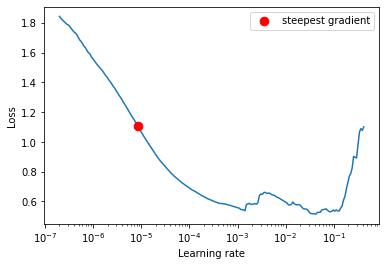

Deleted the fake labels used in Learning rate finder


In [9]:
params = semisup_model.parameters()

### For SGD and Adam ###
learning_rate1, learning_rate2 = 1e-7, 1e-1

### For LBFGS (a good choice already!!!) ###
# print("Using LBFGS's learning rate set")
# learning_rate1, learning_rate2 = 8e-2, 5e-2 # (1e-1, 5e-2) is also OK!

choice = 'MAD'; auto_lr = True
if choice == 'LBFGS':
    optimizer1 = torch.optim.LBFGS(params, lr=learning_rate1, 
                                   max_iter=100, max_eval=125, 
                                  history_size=120, line_search_fn='strong_wolfe')
if choice == 'Adam':
    optimizer1 = AdamGC(params, lr=learning_rate1, use_gc=True, gc_conv_only=False, gc_loc=False)
if choice == 'SGD':
    optimizer1 = SGDGC(params, lr=learning_rate1, use_gc=True, nesterov=True, momentum=0.95)
if choice == 'MAD':
    optimizer1 = MADGRAD(params, lr=learning_rate1, momentum=0.9)

if choice != 'LBFGS' and auto_lr:
    print('Learning rate finding')
    bs = 4000; bs = X_u_train.shape[0] if bs>X_u_train.shape[0] else bs
    criterion = LadderLoss(return_list=True)
    trainloader = get_dataloader(X_u_train, u_train, bs=bs)
    
    lr_finder = LRFinder(semisup_model, optimizer=optimizer1, 
                         closure=pcgrad_update, criterion=criterion, device="cpu")
    lr_finder.range_test(trainloader, val_loader=None, end_lr=100, num_iter=300)
    
    # to inspect the loss-learning rate graph
    suggested_lr, _ = lr_finder.plot()
    # To prevent divergence during the second stage training.
    # suggested_lr = min(suggested_lr, 5e-3)
    lr_finder.reset(); plt.show()

else:
    lr_finder = None
    suggested_lr = None
    
print("Deleted the fake labels used in Learning rate finder")
u_train = u_train[:N, :]

In [10]:
# Set the learing_rate to the suggested one.
# suggested_lr = 1e-5

if lr_finder and suggested_lr:
    optimizer1 = lr_finder.optimizer

for g in optimizer1.param_groups:
    g['lr'] = suggested_lr

epochs1 = 1000; epochs2 = 10000;

In [11]:
# Setting up the generator
generator = TorchMLP([2, 50, 50, 2])
# generator_training_epochs indicates how string the generator is
adv_f = 100; generator_training_epochs = 300; generator_training_limit = epochs1-100
# I can use the Learning rate finder to find a good lr for the generator optim  as well
generator_optimizer = torch.optim.SGD(generator.parameters(), lr=3e-4, momentum=0.95)
sinkhorn_loss = SamplesLoss("sinkhorn", p=2, blur=1.0)

Using old implementation of TorchMLP. See models.py for more new model-related source code.


### Experiments with the generator

In [12]:
curr_loss = 1000; F_print = 10 if choice == 'LBFGS' else 100

# Stage I
# How long should I pretrain selector part of the model?
for i in range(epochs1):
    if i%adv_f==0 and i<=generator_training_limit:
        best_generator_loss = 1000; best_generator_state_dict = None
        o_tensor = X_u_train[:N, :] # or X_u_train ?
        print("Training the generator for ")
        for _ in trange(generator_training_epochs):
            semisup_model.eval()
            generator.train()
            generator_optimizer.zero_grad()
            X_gen = scale_to_range(generator(o_tensor), lb, ub)
            unsup_loss = semisup_model(X_gen)[1]
#                 d_loss = F.mse_loss(X_gen, o_tensor)
            d_loss = F.mse_loss(X_gen, o_tensor)
            generator_loss = d_loss-unsup_loss
            generator_loss.backward(retain_graph=True)
            generator_optimizer.step()
            # Saving the best_generator_state_dict
            if generator_loss.item() < best_generator_loss:
                best_generator_loss = generator_loss.item()
                best_generator_state_dict = generator.state_dict()

        print("The best generator loss:", best_generator_loss)
        generator.load_state_dict(best_generator_state_dict)
        generator.eval()
        X_gen = scale_to_range(generator(o_tensor), lb, ub)
        if N_res<X_gen.shape[0]: X_gen = sampling_from_rows(X_gen, N_res)
        X_u_train = torch.cat([X_u_train[:N, :], X_gen], dim=0).detach().requires_grad_(True)

    semisup_model.train()
    generator_optimizer.zero_grad()
    optimizer1.step(pcgrad_closure)
    l = pcgrad_closure()
    if (i % F_print) == 0:
        if l.item() != curr_loss:
            curr_loss = l.item()
        else:
            print("Semi-supervised solver loss @Epoch {}: ".format(i), curr_loss)
            print("Finishing the first stage")
            break
        print("Semi-supervised solver loss @Epoch {}: ".format(i), curr_loss)

  0%|          | 0/300 [00:00<?, ?it/s]

Training the generator for 


100%|██████████| 300/300 [00:24<00:00, 12.08it/s]


The best generator loss: -1.6442101001739502
Semi-supervised solver loss @Epoch 0:  1.8183863162994385


  1%|          | 2/300 [00:00<00:20, 14.27it/s]

Training the generator for 


100%|██████████| 300/300 [00:22<00:00, 13.50it/s]


The best generator loss: 0.17579790949821472
Semi-supervised solver loss @Epoch 100:  0.5970290303230286


  1%|          | 2/300 [00:00<00:21, 13.70it/s]

Training the generator for 


100%|██████████| 300/300 [00:23<00:00, 12.81it/s]


The best generator loss: 0.2185293436050415
Semi-supervised solver loss @Epoch 200:  0.5214519500732422


  1%|          | 2/300 [00:00<00:20, 14.71it/s]

Training the generator for 


100%|██████████| 300/300 [00:23<00:00, 12.94it/s]


The best generator loss: -0.08315297961235046
Semi-supervised solver loss @Epoch 300:  0.5067567229270935


  1%|          | 2/300 [00:00<00:21, 14.06it/s]

Training the generator for 


100%|██████████| 300/300 [00:21<00:00, 13.89it/s]


The best generator loss: -0.11503279209136963
Semi-supervised solver loss @Epoch 400:  0.48989951610565186


  1%|          | 2/300 [00:00<00:22, 13.29it/s]

Training the generator for 


100%|██████████| 300/300 [00:20<00:00, 14.34it/s]


The best generator loss: -0.4199342131614685
Semi-supervised solver loss @Epoch 500:  0.47590503096580505


  1%|          | 2/300 [00:00<00:20, 14.75it/s]

Training the generator for 


100%|██████████| 300/300 [00:21<00:00, 13.71it/s]


The best generator loss: -0.4587344527244568
Semi-supervised solver loss @Epoch 600:  0.46897366642951965


  1%|          | 2/300 [00:00<00:22, 13.07it/s]

Training the generator for 


100%|██████████| 300/300 [00:24<00:00, 12.12it/s]


The best generator loss: -0.47246110439300537
Semi-supervised solver loss @Epoch 700:  0.45698490738868713


  1%|          | 2/300 [00:00<00:25, 11.48it/s]

Training the generator for 


100%|██████████| 300/300 [00:24<00:00, 12.39it/s]


The best generator loss: -0.5762375593185425
Semi-supervised solver loss @Epoch 800:  0.5488587021827698


  1%|          | 2/300 [00:00<00:23, 12.60it/s]

Training the generator for 


100%|██████████| 300/300 [00:23<00:00, 12.87it/s]


The best generator loss: -0.3720141053199768
Semi-supervised solver loss @Epoch 900:  0.4687098264694214


In [13]:
optimizer2 = LBFGSNew(semisup_model.network.parameters(), 
                              lr=learning_rate2, max_iter=300, max_eval=int(300*1.25),
                              history_size=120, line_search_fn=True, batch_mode=False)

curr_loss = 1000
# Stage II
semisup_model.train()
for i in range(5000):
    optimizer2.step(closure)
    l = closure()
    if (i % 100) == 0:
        if l.item() != curr_loss:
            curr_loss = l.item()
        else:
            print("Finishing the second stage")
            break
        print("Epoch {}: ".format(i), curr_loss)

Epoch 0:  8.112581895147741e-07
Epoch 100:  2.3375262969693722e-07
Epoch 200:  1.2356265699509095e-07
Epoch 300:  8.124590067382087e-08
Epoch 400:  6.14313577784742e-08
Epoch 500:  5.1933504607859504e-08
Epoch 600:  4.6033708400727846e-08
Epoch 700:  4.098594175161452e-08
Epoch 800:  3.555526362220007e-08
Epoch 900:  3.365540379718368e-08
Epoch 1000:  2.8940812413225103e-08
Epoch 1100:  2.6747771997293057e-08
Epoch 1200:  2.0703986081116454e-08
Epoch 1300:  1.661693538324016e-08
Epoch 1400:  1.2467482157774157e-08
Epoch 1500:  1.1432092605900834e-08
Epoch 1600:  9.39306143976637e-09
Epoch 1700:  8.562788700317014e-09
Epoch 1800:  7.62174057200582e-09
Epoch 1900:  6.479115022273163e-09
Epoch 2000:  6.2543019652139265e-09
Epoch 2100:  5.123281798802282e-09
Epoch 2200:  4.890881477592757e-09
Epoch 2300:  4.514059348537103e-09
Epoch 2400:  3.689117233918182e-09
Epoch 2500:  3.366538381399664e-09
Epoch 2600:  3.005511617359957e-09
Epoch 2700:  2.917539321245499e-09
Epoch 2800:  2.6574167311

In [14]:
print("Testing")
semisup_model.network.eval()
# Compare btw the two semi-supervise learning?
test_performance = F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star).item()
string_test_performance = scientific2string(test_performance)
print('Test MSE:', string_test_performance)

Testing
Test MSE: 7.6e-03


In [19]:
der = semisup_model.network.get_selector_data(*dimension_slicing(X_star))[0]
semisup_model.selector.weighted_features(der)

tensor([1., 1., 1., 0., 0.])

In [29]:
feature_importance = (semisup_model.selector.latest_weighted_features).detach().numpy()

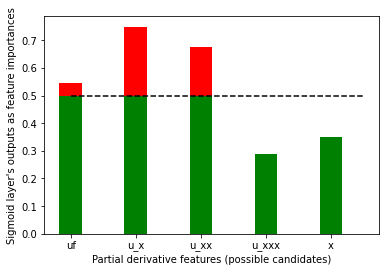

In [55]:
# plt.bar(feature_names, feature_importance)
# plt.xlabel("Partial derivative features (possible candidates)")
# plt.ylabel("Feature importance from the sigmoid layer")
# plt.show()

def plot_feature_importance_neural_net(feature_importances, feature_names, threshold=0.5, save_path=None):
    # split it up
    above_threshold = np.maximum(feature_importance - threshold, 0)
    below_threshold = np.minimum(feature_importance, threshold)

    # and plot it
    fig, ax = plt.subplots()
    ax.bar(feature_names, below_threshold, 0.35, color="g")
    ax.bar(feature_names, above_threshold, 0.35, color="r",
            bottom=below_threshold)
    # horizontal line indicating the threshold
    ax.plot([0., 4.5], [threshold, threshold], "k--")
    plt.xlabel("Partial derivative features (possible candidates)")
    plt.ylabel("Sigmoid layer's outputs as feature importances")
    
    if save_path is not None: fig.savefig(save_path, dpi=200)

plot_feature_importance_neural_net(feature_importance, feature_names, save_path='./visualization/tmp.png')

In [ ]:
# BEST-2000: 1e-06 (LBFGS)
# For saving the plain neural networks.
# print("Saving")
# MODEL_PATH = './saved_path_inverse_burger/export_publication/semisup_model_with_LayerNormDropout_without_physical_reg_trained250labeledsamples_trained125unlabeledsamples_'+string_test_performance+'.pth'
# torch.save(semisup_model.state_dict(), MODEL_PATH)

# torch.save(semisup_model.state_dict(), "./saved_path_inverse_burger/semisup_model_with_LayerNormDropout_without_physical_reg_trained2000labeledsamples_trained1000unlabeledsamples.pth")

In [ ]:
# Loading the best model and testing
# semisup_model.load_state_dict(torch.load(MODEL_PATH), strict=False)
# semisup_model.eval()
# F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star)

In [ ]:
# derivatives_test, dynamics_test = semisup_model.network.get_selector_data(*dimension_slicing(X_star))
# derivatives_train, dynamics_train = semisup_model.network.get_selector_data(*dimension_slicing(X_u_train))

# derivatives_test, dynamics_test = to_numpy(derivatives_test), to_numpy(dynamics_test)
# derivatives_train, dynamics_train = to_numpy(derivatives_train), to_numpy(dynamics_train)

# np.save("./saved_path_inverse_burger/lbfgsnew_results/data/derivatives-2000-V1.npy", derivatives_train)
# np.save("./saved_path_inverse_burger/lbfgsnew_results/data/dynamics-2000-V1.npy", dynamics_train)
# np.save("./saved_path_inverse_burger/lbfgsnew_results/data/derivatives-25600-V1.npy", derivatives_test)
# np.save("./saved_path_inverse_burger/lbfgsnew_results/data/dynamics-25600-V1.npy", dynamics_test)

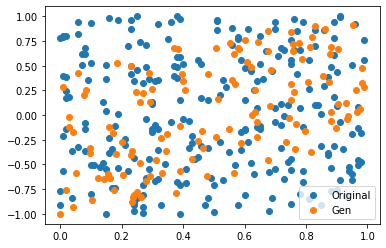

In [22]:
original_samples = to_numpy(X_u_train[:N, :])
generated_samples = to_numpy(X_gen)
x = original_samples[:, 0:1]
t = original_samples[:, 1:2]
x_g = generated_samples[:, 0:1]
t_g = generated_samples[:, 1:2]
plt.scatter(t, x, label='Original')
plt.scatter(t_g, x_g, label='Gen')
plt.legend()
plt.show()